In [117]:
import os
import sys
import shutil
import h5py
from glob2 import glob
import tempfile
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL
from collections import OrderedDict
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split,GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    NormalizeIntensity,
    AddChannel,
    ToTensor,
    MapTransform
)
from monai.utils import set_determinism

In [7]:
root_dir = '/home/polina/projects/test'

## Test cross-validation experimeny with 3 folds

In [115]:
! export CUDA_VISIBLE_DEVICES=0 && python3 ../main.py --exec_mode evaluate --data /home/polina/projects/test/data/ --results /home/polina/projects/test/results --experiment_name baseline_GroupShuffleSplit_fold_0 --cross_val --aug --scheduler --amp --ckpt_path /home/polina/projects/test/results/PlaneClassification/2ood5smt/checkpoints/best_epoch*.ckpt

Global seed set to 42
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:95: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:114: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:88: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:107: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
Dataset split: 
 [1915  624 1196 1612] training, [851 304 535 618] validation, [

## Evaluation on test part of each fold

In [78]:
val_transforms = Compose([AddChannel(),
                        NormalizeIntensity(),
                        ToTensor()])

In [100]:
class PlaneDataset(Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]
    
def load_checkpoints(path):
    state_dict = torch.load(path)['state_dict']
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        if 'model' in k:
            k = k[6:]
        new_state_dict[k]=v
    return new_state_dict

In [118]:
name_id = ['2ood5smt','3qk08efu', '39xdxi70']
weights = [glob(f'{root_dir}/results/PlaneClassification/{exp}/checkpoints/best*.ckpt')[0] for exp in name_id]
nfolds=3
seed=42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [121]:
datah5py = h5py.File(os.path.join(root_dir, 'data', 'plane_classification'))
img, plane_id, sub_id, y = [datah5py[k] for k in datah5py.keys()] 
y_label_encoding = LabelEncoder().fit_transform(y)      
kfold = GroupShuffleSplit(n_splits=nfolds,train_size=.7, random_state=seed)
fold_pred=[]
fold_y=[]
for fold in range(nfolds):
    model = DenseNet121(spatial_dims=2, in_channels=1,
                        out_channels=4).to(device)
    model.load_state_dict(load_checkpoints(os.path.join(root_dir, weights[fold])))
    _, val_idx = list(kfold.split(np.array(img), np.array(y_label_encoding), np.array(sub_id)))[fold] 
    val_ds = PlaneDataset(np.array(img)[val_idx],np.array(y_label_encoding)[val_idx], val_transforms)
    test_loader = DataLoader(val_ds, batch_size=64, num_workers=10)
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for test_data in tqdm(test_loader):
            test_images, test_labels = (
                 test_data[0].to(device),
                 test_data[1].to(device),
            )
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())
    fold_pred.append(y_pred)
    fold_y.append(y_true)

100%|███████████████████████████████████████████████████████████████| 37/37 [00:08<00:00,  4.61it/s]


In [90]:
name_lab = ['too Deep', 'optimal (“Good”)', 'too Shallow', 'bad interface']
name_dict = {0:'too Deep',1: 'optimal (“Good”)', 2:'too Shallow', 3:'bad interface'}

## Out of fold classification report 

In [123]:
print(classification_report(
    y_true, y_pred, target_names=name_lab))

                  precision    recall  f1-score   support

        too Deep       0.79      0.90      0.84       931
optimal (“Good”)       0.54      0.55      0.55       297
     too Shallow       0.86      0.62      0.72       517
   bad interface       0.87      0.89      0.88       561

        accuracy                           0.79      2306
       macro avg       0.77      0.74      0.75      2306
    weighted avg       0.79      0.79      0.79      2306



<AxesSubplot:>

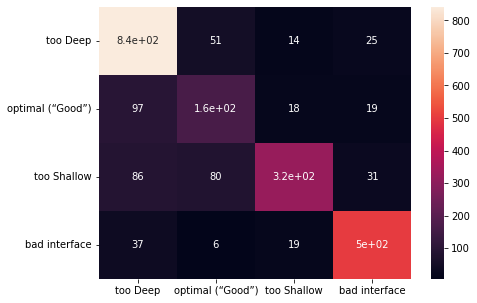

In [124]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true, y_pred)).rename(columns=name_dict, index=name_dict)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

In [125]:
confusion_matrix_df

,too Deep,optimal (“Good”),too Shallow,bad interface
too Deep,841,51,14,25
optimal (“Good”),97,163,18,19
too Shallow,86,80,320,31
bad interface,37,6,19,499


## Classification report of  0 Fold

In [126]:
print(classification_report(
    fold_y[0], fold_pred[0], target_names=name_lab))

                  precision    recall  f1-score   support

        too Deep       0.77      0.88      0.82       851
optimal (“Good”)       0.59      0.47      0.52       304
     too Shallow       0.77      0.77      0.77       535
   bad interface       0.97      0.86      0.91       618

        accuracy                           0.80      2308
       macro avg       0.77      0.75      0.76      2308
    weighted avg       0.80      0.80      0.79      2308



<AxesSubplot:>

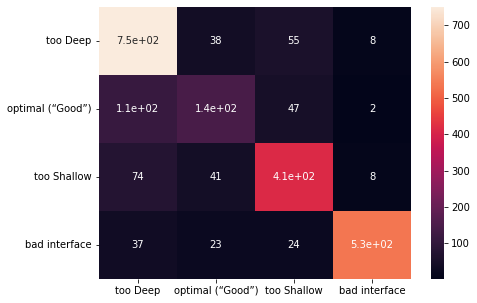

In [128]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(fold_y[0], fold_pred[0])).rename(columns=name_dict, index=name_dict)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

In [129]:
confusion_matrix_df

,too Deep,optimal (“Good”),too Shallow,bad interface
too Deep,750,38,55,8
optimal (“Good”),111,144,47,2
too Shallow,74,41,412,8
bad interface,37,23,24,534


## Classification report of  1 Fold

In [130]:
print(classification_report(
    fold_y[1], fold_pred[1], target_names=name_lab))

                  precision    recall  f1-score   support

        too Deep       0.81      0.90      0.85       819
optimal (“Good”)       0.71      0.44      0.55       270
     too Shallow       0.77      0.83      0.80       470
   bad interface       0.96      0.95      0.95       747

        accuracy                           0.85      2306
       macro avg       0.81      0.78      0.79      2306
    weighted avg       0.84      0.85      0.84      2306



<AxesSubplot:>

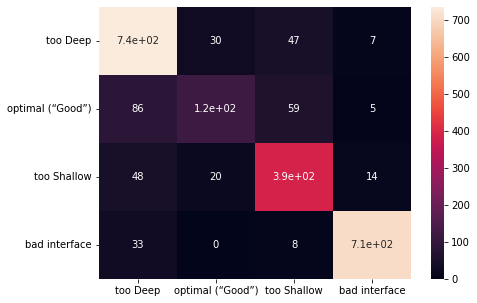

In [132]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(fold_y[1], fold_pred[1])).rename(columns=name_dict, index=name_dict)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

## Classification report of  2 Fold

In [131]:
print(classification_report(
    fold_y[2], fold_pred[2], target_names=name_lab))

                  precision    recall  f1-score   support

        too Deep       0.79      0.90      0.84       931
optimal (“Good”)       0.54      0.55      0.55       297
     too Shallow       0.86      0.62      0.72       517
   bad interface       0.87      0.89      0.88       561

        accuracy                           0.79      2306
       macro avg       0.77      0.74      0.75      2306
    weighted avg       0.79      0.79      0.79      2306



<AxesSubplot:>

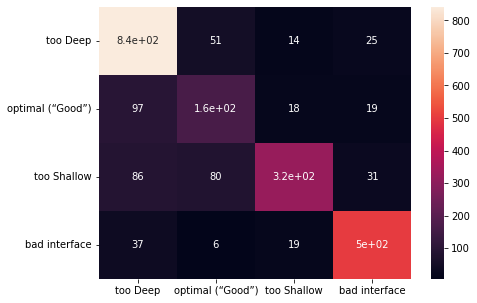

In [133]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(fold_y[2], fold_pred[2])).rename(columns=name_dict, index=name_dict)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)